Goal of this notebook is to apply natural language processing (NLP) on the app names, to predict rating bin.
For inspiration the nlp chapter of the udemy course was used.

In [89]:
import nltk
import os
import pandas as pd
import seaborn as sns
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [74]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to C:\Users\~LarsSpekscho
[nltk_data]    |     orTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to C:\Users\~LarsSpeks
[nltk_data]    |     choorTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to C:\Users\~LarsSpekscho
[nltk_data]    |     orTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to C:\Users\~LarsSpeksc
[nltk_data]    |     hoorTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to C:\Users\~LarsSpeksc
[nltk_data]    |     hoorTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already 

True

In [51]:
# Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
path = os.getcwd() + "/../data/Google-Playstore-Modified_w_ohe_y_w_name.parquet"
df = pd.read_parquet(path, engine='fastparquet')

In [52]:
df.head()

,App Name,App Id,Category,Rating,Rating Count,Maximum Installs,Free,Price,Last Updated,Ad Supported,In App Purchases,Super Category,Rating Bin,Moderate,Superb,Bad App Yo,Other,Personal & Social,Entertainment,Development
0,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64,7662,True,0.0,"May 06, 2021",True,False,Other,Moderate,0,1,0,0,0,1,0
1,unlimited 4G data prank free app,getfreedata.superfatiza.unlimitedjiodataprank,Libraries & Demo,4.5,12,2567,True,0.0,"Sep 27, 2019",True,False,Other,Superb,0,0,1,0,0,1,0
2,The Everyday Calendar,com.mozaix.simoneboard,Lifestyle,2.0,39,702,True,0.0,"Jun 21, 2019",False,False,Personal & Social,Bad App Yo,1,0,0,0,0,0,1
3,Neon 3d Iron Tech Keyboard Theme,com.ikeyboard.theme.neon_3d.iron.tech,Personalization,4.7,820,62433,True,0.0,"Oct 07, 2020",True,False,Personal & Social,Superb,0,0,1,0,0,0,1
4,Dodge The Cars!,com.MrScratchEnterprises.CarDogeGame,Racing,4.9,55,329,True,0.0,"Jul 30, 2020",False,False,Entertainment,Superb,0,0,1,0,1,0,0


In [101]:
#Next two lines were moved to feature engineering
#df['App Name'] = df['App Name'].apply(str)
#df['Name Name Length'] = df['App Name'].apply(len)
df = df[['App Name', 'Rating Bin', 'Name Length']]
print(df.head())
df.groupby('Rating Bin').describe()

C:\Users\~LarsSpekschoorTrain\AppData\Local\Temp\ipykernel_1092\854322635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['App Name'] = df_nlp['App Name'].apply(str)
C:\Users\~LarsSpekschoorTrain\AppData\Local\Temp\ipykernel_1092\854322635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['length'] = df_nlp['App Name'].apply(len)


                           App Name  Rating Bin  length
0               Ampere Battery Info    Moderate      19
1  unlimited 4G data prank free app      Superb      32
2             The Everyday Calendar  Bad App Yo      21
3  Neon 3d Iron Tech Keyboard Theme      Superb      32
4                   Dodge The Cars!      Superb      15


length                                                   
               count       mean        std  min   25%   50%   75%   max
Rating Bin                                                             
Bad App Yo  232779.0  21.889986  12.136059  2.0  12.0  19.0  29.0  50.0
Moderate    292342.0  24.123181  12.327928  1.0  14.0  22.0  31.0  50.0
Superb      280900.0  22.884343  12.493124  1.0  13.0  20.0  30.0  50.0

How is the Name Length of app name distributed?

<AxesSubplot: xlabel='length', ylabel='Density'>

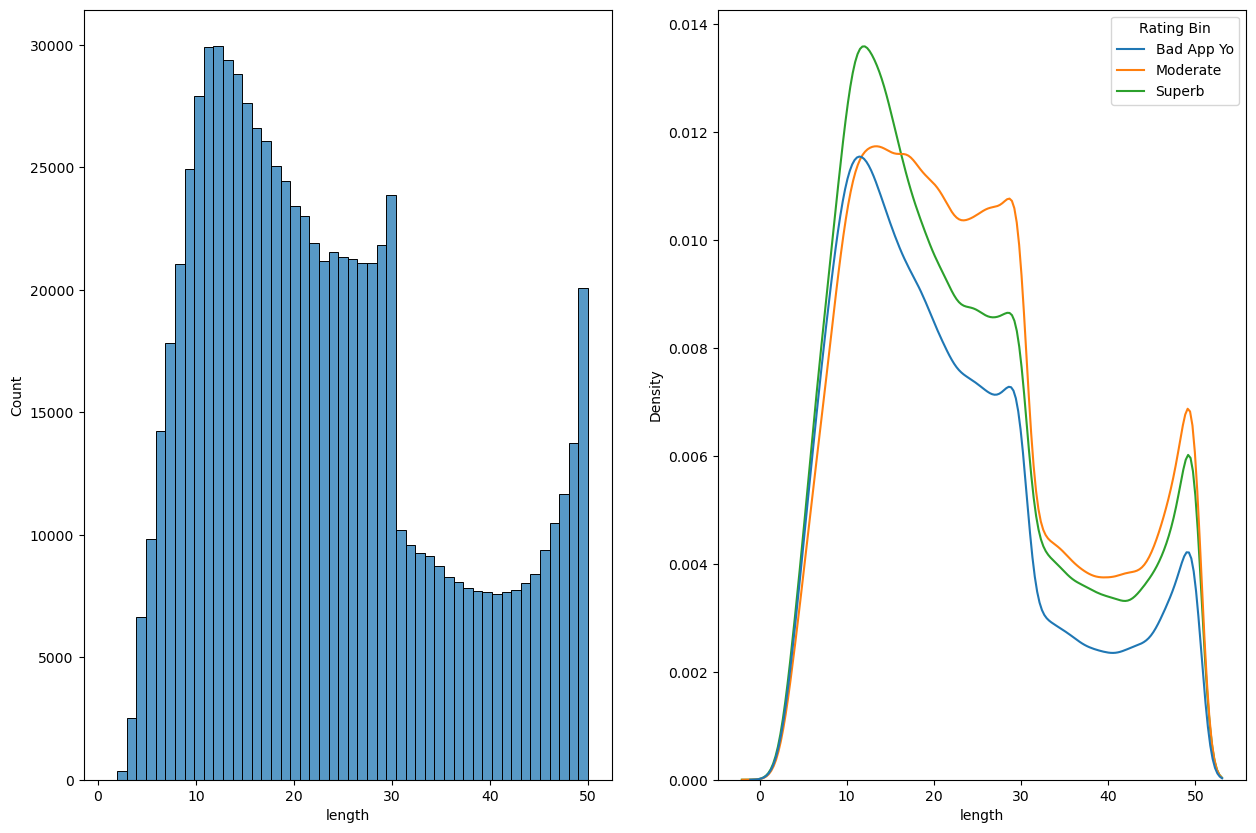

In [92]:
fig, axs = plt.subplots(1,2, figsize=(15, 10))
sns.histplot(x = df['Name Length'], bins=50, ax=axs[0])
sns.kdeplot(x = df['Name Length'], hue=df['Rating Bin'], ax=axs[1])

Is there something off about the longer app names?
Yes, there are many apps with length 30 or 50, because these represent a new and old maximum length set by Google resp.
Abbreviated names end with '...', this could serve as a categorical cutoff point.
The punctuation will also be handled in text processing, but any remaining parts of cut-off words won't be treated for now. The assumption is there will only be a minimal effect from coincidental word parts.

In [62]:
df[df['Name Length'] > 45].head(25)

,App Name,Rating Bin,length
34,Delhi Public Transport - Metro and DTC Bus Routes,Bad App Yo,49
45,Notes2Go - Take Notes and Set Reminders On the Go,Superb,49
46,Mega Ramps Car Stunts: Ultimate Races Car Games,Moderate,47
54,Easy Urdu Keyboard:Urdu and English Keyboard 2020,Superb,49
75,Make Money Online - Best & Easy Ways to Earn M...,Moderate,50
80,"UG Bazaar: Automobiles, Jobs, Buy, Sell in Nepal",Moderate,48
93,H. Muammar ZA Bimbingan Tilawatil Quran Offline,Moderate,47
103,Bebe Rexha The Best New Music Video Collection,Moderate,46
127,E Currency & Money Converter- Exchange Rate 2021,Superb,48
153,Virtual Baby Simulator - Mother Simulator 2020,Moderate,47


In [84]:
print(string.punctuation)
print(stopwords.words('english'))


def text_process(mess):
    """
    1. remove punc
    2. remove stop words
    3. return list of clean text words
    """
    nopunc = ''.join([c for c in mess if c not in string.punctuation])
    clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

text_process('Message that has interpunction and stopwords, or does it not?!')
df['App Name'].head(10).apply(text_process)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

0                    [Ampere, Battery, Info]
1    [unlimited, 4G, data, prank, free, app]
2                       [Everyday, Calendar]
3    [Neon, 3d, Iron, Tech, Keyboard, Theme]
4                              [Dodge, Cars]
5              [桃園機場捷運時刻表, 捷運轉乘路線快速查詢支援台北捷運]
6                       [Caliway, Conductor]
7                  [Readymade, Grocery, App]
8                           [REDMOND, Robot]
9                [Block, Fill, Puzzle, Game]
Name: App Name, dtype: object

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
#first run took 14m 2.0s on laptop
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['App Name'])

In [99]:
print('Dataframe shape: ', str(df.shape))
print('Bow transformer vocabulary length: ', str(len(bow_transformer.vocabulary_)))

Dataframe shape:  (806021, 3)
Bow transformer vocabulary length:  444275


In [97]:
#first run took 13m 17.4s on laptop
names_bow = bow_transformer.transform(df['App Name'])

In [103]:
print('Shape of Sparse Matrix: ', names_bow.shape)
print('Non-zero occurances: ', names_bow.nnz)

sparsity = (100.0 * names_bow.nnz / (names_bow.shape[0] * names_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

Shape of Sparse Matrix:  (806021, 444275)
Non-zero occurances:  2658655
sparsity: 0.0007424440861110366
